---
# <div align="center"> Final Project: Facial Keypoints Detection</div>

## Introduction

The objective of this task is to predict keypoint positions on face images.

Accuracy is evaluated on the root mean squared error. RMSE is very common and is a suitable general-purpose error metric. Compared to the Mean Absolute Error, RMSE punishes large errors:

$$ RMSE = \sqrt{\frac{1}{n}. \sum_{i=1}^{n}{(y_i - \hat{y_i})^2}}$$

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import os
import re
import sys
import numpy as np
import matplotlib.pyplot as plt
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle

from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import time

import theano 
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
from theano.tensor.nnet import conv2d
from theano.tensor.signal.pool import pool_2d

print(theano.config.device)
print(theano.config.floatX)
print(sys.version)


WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

/home/ec2-user/anaconda3/lib/python3.6/site-packages/theano/sandbox/cuda/__init__.py:556: UserWarning: Theano flag device=gpu* (old gpu back-end) only support floatX=float32. You have floatX=float64. Use the new gpu back-end with device=cuda* for that value of floatX.
  warnings.warn(msg)
Using gpu device 0: GRID K520 (CNMeM is disabled, cuDNN 5103)


gpu
float64
3.6.1 |Anaconda 4.4.0 (64-bit)| (default, May 11 2017, 13:09:58) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


In [2]:
## Specify the path to the datasets
TRAIN = "../../../data/facial_keypoints/training.csv"
TEST = "../../../data/facial_keypoints/test.csv"

In [3]:
def load_data(path):
    ## load pandas dataframe
    df = read_csv(os.path.expanduser(path))  
    ## The Image column has pixel values separated by space 
    ## convert the pixel values to numpy arrays
    df["Image"] = df["Image"].apply(lambda im: np.fromstring(im, sep=" "))
    ## drop all rows that have missing values in them
    df = df.dropna()  
    return df

## Loading and Exploring the Dataset

In [4]:
rawdata = load_data(TRAIN)

In [5]:
## Number of non-NA rows per each column
rawdata.count()

left_eye_center_x            2140
left_eye_center_y            2140
right_eye_center_x           2140
right_eye_center_y           2140
left_eye_inner_corner_x      2140
left_eye_inner_corner_y      2140
left_eye_outer_corner_x      2140
left_eye_outer_corner_y      2140
right_eye_inner_corner_x     2140
right_eye_inner_corner_y     2140
right_eye_outer_corner_x     2140
right_eye_outer_corner_y     2140
left_eyebrow_inner_end_x     2140
left_eyebrow_inner_end_y     2140
left_eyebrow_outer_end_x     2140
left_eyebrow_outer_end_y     2140
right_eyebrow_inner_end_x    2140
right_eyebrow_inner_end_y    2140
right_eyebrow_outer_end_x    2140
right_eyebrow_outer_end_y    2140
nose_tip_x                   2140
nose_tip_y                   2140
mouth_left_corner_x          2140
mouth_left_corner_y          2140
mouth_right_corner_x         2140
mouth_right_corner_y         2140
mouth_center_top_lip_x       2140
mouth_center_top_lip_y       2140
mouth_center_bottom_lip_x    2140
mouth_center_b

We see that each keypoint has different number of observations. It may be due to that some face images does not show direct front angle. In order to utilize as much training data as we can, we will build multiple models each capturing different set of facial keypoints. 

In the following steps:

1. Each image pixel is bound between [0,1]
2. Each keypoint location is bound between [0,1] and set the center to be position 0
3. Transform training image set and keypoint labels set into numeric arrays. 
4. Shuffle both the training set and labels
5. Create both training and development sets

In [6]:
X = np.vstack(rawdata["Image"].values) / 255
Y = (rawdata[rawdata.columns[:-1]].values - 48) / 48

X, Y = shuffle(X, Y)

X = X.astype(theano.config.floatX)
Y = Y.astype(theano.config.floatX)
print("Raw training image data shape:", X.shape)
print("Raw training data keypoint shape:", Y.shape)

num_dev = int(len(X)/7)
train_data, train_labels = X[num_dev:], Y[num_dev:]
dev_data, dev_labels = X[:num_dev], Y[:num_dev]

print("Number of training examples:", len(train_data))
print("Number of dev examples:", len(dev_data))

Raw training image data shape: (2140, 9216)
Raw training data keypoint shape: (2140, 30)
Number of training examples: 1835
Number of dev examples: 305


We then want to subset the data by different keypoint sets.

In [7]:
full_keypoints = (rawdata.columns.values).tolist()[:-1]

def subset_data(x, y, keypoints):
    """
    The function subsets the label data based on the keypoints
    specified and returns the training data and subsetted 
    training labels with complete keypoint position labeling.
    
    Input:
        - x: training image data. (ndarray)
        - y: training keypoint label data. (ndarray)
        - keypoints: list of column names wanted
    Output:
        - x: training image data with complete keypoint labeling. (ndarray)
        - y: subsetted keypoint label data. (ndarray)
    """
    cols = []
    for col in keypoints:
        if col in full_keypoints:
            cols.append(full_keypoints.index(col))
    y_subset = y[:,cols]
    ## only select the examples that has complete keypoint values
    complete = (np.sum((np.isnan(y_subset) == True)*1, axis=1) == 0).tolist()
    x, y = x[complete,:], y_subset[complete,:]
    return x, y
    

In [8]:
eye_center_cols = ["left_eye_center_x", "left_eye_center_y",
                   "right_eye_center_x", "right_eye_center_y"]

eye_corner_cols = ["left_eye_inner_corner_x", "left_eye_inner_corner_y",
                   "left_eye_outer_corner_x", "left_eye_outer_corner_y",
                   "right_eye_inner_corner_x", "right_eye_inner_corner_y",
                   "right_eye_outer_corner_x", "right_eye_outer_corner_y"]

eyebrow_cols = ["left_eyebrow_inner_end_x", "left_eyebrow_inner_end_y",
                "left_eyebrow_outer_end_x", "left_eyebrow_outer_end_y",
                "right_eyebrow_inner_end_x", "right_eyebrow_inner_end_y",
                "right_eyebrow_outer_end_x", "right_eyebrow_outer_end_y"]

nose_cols = ["nose_tip_x", "nose_tip_y"]

mouth_corner_cols = ["mouth_left_corner_x", "mouth_left_corner_y",
                     "mouth_right_corner_x", "mouth_right_corner_y"]

mouth_center_top_cols = ["mouth_center_top_lip_x", "mouth_center_top_lip_y"]

mouth_center_bottom_cols = ["mouth_center_bottom_lip_x", "mouth_center_bottom_lip_y"]

eye_ct_data, eye_ct_labels = subset_data(train_data, train_labels, eye_center_cols)
eye_cr_data, eye_cr_labels = subset_data(train_data, train_labels, eye_corner_cols)
eyebrow_data, eyebrow_labels = subset_data(train_data, train_labels, eyebrow_cols)
nose_data, nose_labels = subset_data(train_data, train_labels, nose_cols)
mouth_cr_data, mouth_cr_labels = subset_data(train_data, train_labels,
                                                     mouth_corner_cols)
mouth_ct_top_data, mouth_ct_top_labels = subset_data(train_data, train_labels,
                                                     mouth_center_top_cols)
mouth_ct_bottom_data, mouth_ct_bottom_labels = subset_data(train_data, train_labels,
                                                           mouth_center_bottom_cols)

## Ploting

In [9]:
def plot_sample_image(x, y, plot):
    pixels = x.reshape(96,96)
    plot.imshow(pixels, cmap="gray")
    plot.scatter((y[0::2]*48)+48, (y[1::2]*48)+48,
                 marker="x", c="red", s=20)  


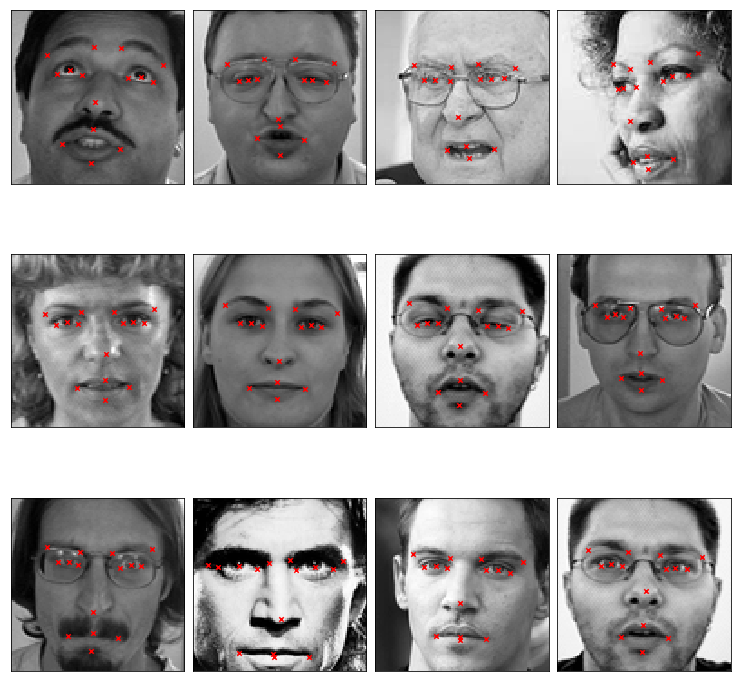

In [10]:
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(12):
    axplot = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    plot_sample_image(train_data[i], train_labels[i], axplot)

## Convolutional Neural Network

#### (1) Parameters

In [7]:
miniBatchSize = 10
N = miniBatchSize #Number of samples to compute the mean squared error
numClasses = train_labels[1].size #Number of outputs we require
numFeatures = train_data[1].size #Number of inputs

## Number of feature maps, filter map size and number of hidden nodes
numHiddenNodes = 600 
patchWidth = 5
patchHeight = 5
featureMapsLayer1 = 32
featureMapsLayer2 = 64
featureMapsLayer3 = 128

## For convonets, we will work in 2d rather than 1d.
imageWidth = 96
train_data = train_data.reshape(-1, 1, imageWidth, imageWidth)
dev_data = dev_data.reshape(-1, 1, imageWidth, imageWidth)

## Convolution layers
w_1 = theano.shared(np.asarray((np.random.randn(*(featureMapsLayer1, 1, patchWidth, patchHeight))*.01)))
w_2 = theano.shared(np.asarray((np.random.randn(*(featureMapsLayer2, featureMapsLayer1, patchWidth, patchHeight))*.01)))
w_3 = theano.shared(np.asarray((np.random.randn(*(featureMapsLayer3, featureMapsLayer2, patchWidth, patchHeight))*.01)))

## Fully connected NN
w_4 = theano.shared(np.asarray((np.random.randn(*(featureMapsLayer3 * 12 * 12, numHiddenNodes))*.01)))
w_5 = theano.shared(np.asarray((np.random.randn(*(numHiddenNodes, numClasses))*.01)))
params = [w_1, w_2, w_3, w_4, w_5]

In [12]:
len(params[1])

TypeError: object of type 'TensorSharedVariable' has no len()

In [10]:
print("training data shape:",train_data.shape)

training data shape: (1835, 1, 96, 96)


#### (2) Model

In [11]:
X = T.tensor4() 
Y = T.matrix()

srng = RandomStreams()
def dropout(X, p=0.):
    if p > 0:
        X *= srng.binomial(X.shape, p = 1-p)
        X /= 1-p
    return X

## Theano provides built-in support for add convolutional layers
def model(X, w_1, w_2, w_3, w_4, w_5, p_1, p_2):
    l1 = dropout(pool_2d(T.maximum(conv2d(X, w_1, border_mode=(2,2)),0.), (2, 2), ignore_border=True), p_1)
    l2 = dropout(pool_2d(T.maximum(conv2d(l1, w_2, border_mode=(2,2)), 0.), (2, 2), ignore_border=True), p_1)
    ## flatten to switch back to 1d layers
    l3 = dropout(T.flatten(pool_2d(T.maximum(conv2d(l2, w_3, border_mode=(2,2)), 0.), (2, 2), ignore_border=True), outdim=2), p_1) 
    l4 = dropout(T.maximum(T.dot(l3, w_4), 0.), p_2)
    return T.dot(l4, w_5)

y_hat_train = model(X, w_1, w_2, w_3, w_4, w_5, 0.2, 0.5)
y_hat_predict = model(X, w_1, w_2, w_3, w_4, w_5, 0., 0.)

#### (3) Cost Function - Mean Squared Error

In [12]:
cost = T.sum(T.pow(y_hat_train-Y,2))/(2*N)

#### (4) Optimization

In [17]:
## Back Propagation
def backprop(cost, w, alpha=0.001, rho=0.9, epsilon=1e-6):
    grads = T.grad(cost=cost, wrt=w)
    updates = []
    for w1, grad in zip(w, grads):
        ## adding gradient scaling
        acc = theano.shared(w1.get_value() * 0.)
        acc_new = rho * acc + (1 - rho) * grad ** 2
        gradient_scaling = T.sqrt(acc_new + epsilon)
        grad = grad / gradient_scaling
        updates.append((acc, acc_new))
        updates.append((w1, w1 - grad * alpha))
    return updates

## Update rule use back prop
update = backprop(cost, params)

## Training function - given input, calls update rule and outputs loss
train = theano.function(inputs=[X, Y], outputs=cost, updates=update, allow_input_downcast=True)

## Prediction function
y_pred = y_hat_predict
predict = theano.function(inputs=[X], outputs=y_pred, allow_input_downcast=True)


def get_validation_loss(pred):
    RMSE = np.sqrt(np.sum((pred-dev_labels)**2)/(2*dev_data.shape[0]))*48
    val_loss = np.sum((pred-dev_labels)**2)/(2*dev_data.shape[0])
    return val_loss, RMSE

loss = []
validation_loss = []
validation_RMSE = []
epochs_ran = []

def gradientDescentStochastic(epochs):
    trainTime = 0.0
    predictTime = 0.0
    start_time = time.time()
    print("Epoch      Cost        RMSE         Epoch Training Time(secs)")
    print("-----      ----        -----        -------------------------")
    for i in range(epochs):
        epochStartTime = time.time()
        for start, end in zip(range(0, len(train_data), miniBatchSize),
                              range(miniBatchSize, len(train_data), miniBatchSize)):
            cost = train(train_data[start:end], train_labels[start:end])
        epochtime = time.time() - epochStartTime
        trainTime =  trainTime + (time.time() - start_time)
        loss.append(cost)
        val_loss, RMSE = get_validation_loss(predict(dev_data))
        validation_loss.append(val_loss)
        validation_RMSE.append(RMSE)
        epochs_ran.append(i+1)
        print("{0:<3}       {1:<0.5f}      {2:<2.3f}            {3:<1.3f}".format(i+1, cost*1.0, np.sqrt(cost)*48, epochtime))
    print("Total training time = %.2f" %(trainTime))


In [ ]:
gradientDescentStochastic(1000)

Epoch      Cost        RMSE         Epoch Training Time(secs)
-----      ----        -----        -------------------------
1         0.24452      23.735            128.342
2         0.21764      22.393            128.064
3         0.10701      15.702            128.068
4         0.14178      18.074            130.432
5         0.26015      24.482            128.431
6         0.44622      32.064            130.028
7         0.15990      19.194            128.532
8         0.15566      18.938            130.263
9         0.33081      27.608            128.879
10        0.43910      31.807            130.492
11        0.20600      21.786            129.042
12        0.14147      18.054            128.730
13        0.54908      35.568            129.805
14        0.22095      22.563            129.223
15        0.29335      25.998            129.399
16        0.22210      22.621            129.342
17        0.20094      21.517            130.236
18        0.40974      30.725            12

166       0.22131      22.581            126.341
167       0.24467      23.743            127.414
168       0.27789      25.304            127.237
169       0.27603      25.218            126.052
170       0.20619      21.796            126.979
171       0.16260      19.355            126.073
172       0.90180      45.582            125.417
173       0.18105      20.424            125.963
174       0.26095      24.520            125.494
175       0.24514      23.765            125.678
176       0.18209      20.483            126.619
177       0.23308      23.174            126.375
178       0.52912      34.915            125.429
179       0.22625      22.832            126.200
180       0.54339      35.383            125.490
181       0.14677      18.389            126.176
182       0.18851      20.840            126.414
183       0.17215      19.916            126.205
184       0.44056      31.860            126.334
185       0.24081      23.555            125.843
186       0.32933   

In [ ]:
gradientDescentStochastic(10)

In [15]:
start_time = time.time()
pred = predict(dev_data)   
print("Prediction time on dev set = %.2f" %(time.time() - start_time))

plt.plot(epochs_ran, loss, linewidth=3, label="training Loss")
plt.plot(epochs_ran, validation_loss, linewidth=3, label="validation Loss")
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

Prediction time on dev set = 4.63


NameError: name 'epochs_ran' is not defined

### Specialist Models


#### Parameters

In [ ]:
miniBatchSize = 10
N = miniBatchSize #Number of samples to compute the mean squared error
numClasses = train_labels[1].size #Number of outputs we require
numFeatures = train_data[1].size #Number of inputs

## Number of feature maps, filter map size and number of hidden nodes
numHiddenNodes = 600 
patchWidth = 5
patchHeight = 5
featureMapsLayer1 = 32
featureMapsLayer2 = 64
featureMapsLayer3 = 128

## For convonets, we will work in 2d rather than 1d.
imageWidth = 96
train_data = train_data.reshape(-1, 1, imageWidth, imageWidth)
dev_data = dev_data.reshape(-1, 1, imageWidth, imageWidth)

## Convolution layers
w_1 = theano.shared(np.asarray((np.random.randn(*(featureMapsLayer1, 1, patchWidth, patchHeight))*.01)))
w_2 = theano.shared(np.asarray((np.random.randn(*(featureMapsLayer2, featureMapsLayer1, patchWidth, patchHeight))*.01)))
w_3 = theano.shared(np.asarray((np.random.randn(*(featureMapsLayer3, featureMapsLayer2, patchWidth, patchHeight))*.01)))

## Fully connected NN
w_4 = theano.shared(np.asarray((np.random.randn(*(featureMapsLayer3 * 12 * 12, numHiddenNodes))*.01)))
w_5 = theano.shared(np.asarray((np.random.randn(*(numHiddenNodes, numClasses))*.01)))
params = [w_1, w_2, w_3, w_4, w_5]